In [1]:
from utils import *
from matplotlib.font_manager import FontProperties
import matplotlib.lines as mlines
plt.rcParams["font.family"] = "Times New Roman"

import pickle as pkl
CACHE_FILE = "matrix_cache"
F_SIZE = 10

In [2]:
if os.path.exists(CACHE_FILE):
    cache = pkl.load(open(CACHE_FILE, "rb"))
else:
    cache = {}
print(f"Cache has {len(cache)} matrices stored")

Cache has 119 matrices stored


In [3]:
def calc_design_matrix(n_samples, params, ranges, binary=True, log=False, use_cache=True): 
    """
    Accepts model parameters and variables ranges, calculates the 
    design matrix M (n_samples, 2 * n_samples) where M[i, j] is the 
    values of Yih's J calculated with the i'th value of n and 
    j'th value of m. 
    """
    N_MIN, N_MAX, N_MIN2, N_MAX2, M_MIN, M_MAX = \
        (ranges["N_MIN"], ranges["N_MAX"], ranges["N_MIN2"], ranges["N_MAX2"], ranges["M_MIN"], ranges["M_MAX"])
    
    rho1, rho2, mu1, d1, g, U0, flow_height = params["rho1"], params["rho2"], \
        params["mu1"], params["d1"], params["g"], params["U0"], params["flow_height"]
    
    key = (n_samples, N_MIN, N_MAX, N_MIN2, N_MAX2, M_MIN, M_MAX, rho1, rho2, mu1, d1, log, g, U0, flow_height)
    
    if key in cache and use_cache:
        print("Using previously cached matrix")
        result = cache[key]
        
        if binary:
            result[result > 0] = 1
            result[result <= 0] = 0
            
        return result
    
    d2s = np.linspace(N_MIN, N_MAX, n_samples)
    mu2s = np.linspace(M_MIN, M_MAX, n_samples) 
    
    if log:
        mu2s = np.ones_like(mu2s) * 10
        mu2s **= np.linspace(M_MIN, M_MAX, n_samples)


    right_d2s = np.linspace(N_MIN2, N_MAX2, n_samples)

    d2s = np.concatenate([d2s, right_d2s])

    results = np.empty((n_samples, 2 * n_samples))

    for i, d2 in enumerate(d2s):
        for j, mu2 in enumerate(mu2s):
            params["d2"] = d2
            params["mu2"] = mu2
            J, F = yihJ(**params)
            results[j, i] = J
    
    cache[key] = results
    pkl.dump(cache, open(CACHE_FILE, "wb"))
    
    if binary:
        results[results > 0] = 1
        results[results <= 0] = 0
    
    return results

In [4]:
#----Creating custom ColorMap using colors from colorbrewer2.com-----#
from matplotlib.colors import ListedColormap

# Blue to red color scheme
color_rgbs = [
[178,24,43],
[239,138,98],
[253,219,199],
[255, 243, 228],
[33,102,172]
]

# 178,24,43
# 239,138,98
# 253,219,199

color_rgbs = [list((c / 256 for c in l)) for l in color_rgbs][::-1]
custom_map = ListedColormap(color_rgbs, name="custom")

custom_map_reduced = ListedColormap(color_rgbs[0:3], name="reduced")

In [5]:
#-------MAKING ONE GRAPH WITH MULTIPLE STABILITY BOUNDARIES-----------#
# we might want to create mu2s logarithmically 

# Controls y-axis of phase diagram
LOG = False


ranges = {
    "N_MIN" : .2,
    "N_MAX" : .9999,

    "N_MIN2" : 1,
    "N_MAX2" : 5,

    "M_MIN" : .1,
    "M_MAX" : .999,
    
    "NUM_LABELS_Y" : 2,
    "NUM_LABELS_X" : 3,
    
    "X_LABELS" : [.2, 1, 5], 

    "N_SAMPLES" : int(1e3)
}

ranges["Y_LABELS"] = [.1, 1]

params = {
    "g" : 9.8,
    "U0": 5,
    "dP" : 0,

    "verbose" : False,

    "mu1" : 1,
    "rho2" : 1,
    "d1" : 1,
    
    "flow_height" : 3
}

In [6]:
rho1s = [.999, .98, .95]
d_matrix_quick = np.zeros((ranges["N_SAMPLES"], 2 * ranges["N_SAMPLES"]))
params["U0"] = 5
d_matrix_quick_stages = []
for rho1 in rho1s:
    params["rho1"] = rho1
    updated_matrix = calc_design_matrix(ranges["N_SAMPLES"], params, ranges, binary=True, log=LOG)
    d_matrix_quick += updated_matrix
    d_matrix_quick_stages.append(updated_matrix)
    
d_matrix_slow = np.zeros((ranges["N_SAMPLES"], 2 * ranges["N_SAMPLES"]))
params["U0"] = 4.5
for rho1 in rho1s:
    params["rho1"] = rho1
    d_matrix_slow += calc_design_matrix(ranges["N_SAMPLES"], params, ranges, binary=True, log=LOG)

Using previously cached matrix
Using previously cached matrix
Using previously cached matrix
Using previously cached matrix
Using previously cached matrix
Using previously cached matrix


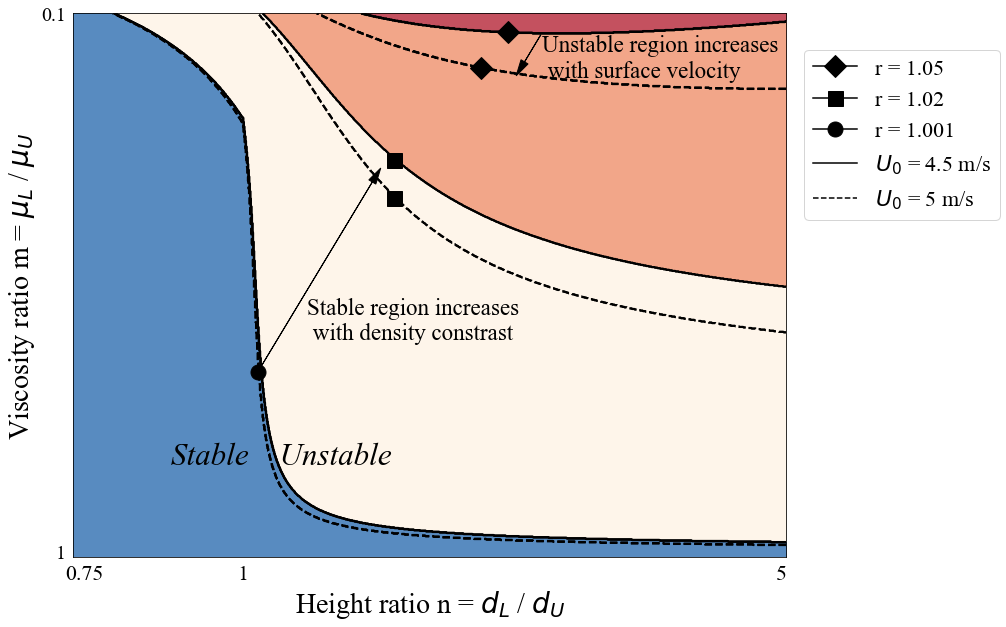

In [7]:
CUTOFF = 688
MARKER_SIZE = 15
LABEL_SIZE = 28
FONT_SIZE = 23

fig, ax = plt.subplots(figsize=(15,10))


im1 = ax.imshow(d_matrix_slow[:, CUTOFF:], cmap=custom_map, interpolation="nearest", alpha=.75)
ax.contour(range(2 * ranges["N_SAMPLES"] - CUTOFF), range(ranges["N_SAMPLES"]), d_matrix_quick[:, CUTOFF:], \
           colors="black", linestyles="dashed", linewidths=2)
ax.contour(range(2 * ranges["N_SAMPLES"] - CUTOFF), range(ranges["N_SAMPLES"]), d_matrix_slow[:, CUTOFF:], \
           colors="black", linewidths=2)

faster_line = mlines.Line2D([], [], color='black', linestyle="dashed", label='$U_0$ = 5 m/s')
slower_line = mlines.Line2D([], [], color='black', label='$U_0$ = 4.5 m/s')
r1_line = mlines.Line2D([], [], color='black', label='r = 1.001', marker="o", markersize=MARKER_SIZE)
r2_line = mlines.Line2D([], [], color='black', label='r = 1.02', marker="s", markersize=MARKER_SIZE)
r3_line = mlines.Line2D([], [], color='black', label='r = 1.05', marker="D", markersize=MARKER_SIZE)

plt.legend(handles=[r3_line, r2_line, r1_line, slower_line, faster_line], \
           loc="lower left", fontsize=22, bbox_to_anchor=(1.01, .6))

plt.tick_params(axis='x', bottom=False)
plt.tick_params(axis='y', left=False)

# tic locations
locs_y = np.linspace(0, ranges["N_SAMPLES"], ranges["NUM_LABELS_Y"])
locs_x = np.linspace(0, 2 * ranges["N_SAMPLES"], ranges["NUM_LABELS_X"])

locs_x = [loc - CUTOFF if idx != 0 else loc for idx, loc in enumerate(locs_x)]

# Keep tics from running off the graph
locs_x[-1] -= 10
locs_y[-1] -= 10

# avoid collision at bottom left corner
locs_x[0] += 20

# tic labels 
y_labels = ranges["Y_LABELS"]
x_labels = ranges["X_LABELS"]
x_labels[0] = round(np.linspace(ranges["N_MIN"], ranges["N_MAX"], ranges["N_SAMPLES"])[CUTOFF], 2)

ax.set_yticks(locs_y)
ax.set_yticklabels(y_labels, fontsize=20)

ax.set_xticks(locs_x)
ax.set_xticklabels(x_labels.copy(), fontsize=22)

# axes labels
ax.set_ylabel("Viscosity ratio m = $\mu_L$ / $\mu_U$", fontsize=LABEL_SIZE)
ax.set_xlabel("Height ratio n = $d_L$ / $d_U$", fontsize=LABEL_SIZE)

# plot additional info

# mark each line distinctly

plt.plot(340, 660, "o", markersize=MARKER_SIZE, color="black")


plt.arrow(345, 650, 205, -340, head_width=15, head_length=30, color="black")

plt.plot(590, 340, "s", markersize=MARKER_SIZE, color="black")
plt.plot(590, 270, "s", markersize=MARKER_SIZE, color="black")

plt.plot(750, 100, "D", markersize=MARKER_SIZE, color="black")
plt.plot(800, 35, "D", markersize=MARKER_SIZE, color="black")

plt.text(862, 117, "Unstable region increases \n with surface velocity", fontsize=FONT_SIZE)

plt.text(430, 600, "Stable region increases\n with density constrast", fontsize=FONT_SIZE)

plt.arrow(860, 39, -30, 50, lw=1, head_width=15, head_length=30, color="black")

#plt.tight_layout()
font = FontProperties()
font.set_style('italic')
plt.text(180, 830, "Stable    Unstable", fontsize=FONT_SIZE + 8, fontproperties=font)

fig.savefig(f"phase_diagrams/final_1-4-21_{params['flow_height']}m", bbox_inches='tight')